# Named Entity Recognition using Bi-LSTM

## BIO?
- 개체명 인식에서 사용되는 보편적인 방법
- B : Begin (개체명이 시작되는 부분)
- I : Inside (개체명의 내부 부분)
- O : Outside (개체명이 아닌 부분)
- ex) 해(B) 리(I) 포(I) 터(I) 보(O) 러(O) 가(O) 자(O)

## 1. Import Dataset

데이터 양식 : [단어] [품사 태깅] [청크 태깅] [개체명 태깅]
- 품사태깅 ex) : NNP = 고유명사 단수형 & VBZ = 3인칭 단수 동사 현재형
- 개체명 태깅 ex) LOC=location & ORG=organization & PER=person
- 공란 : 새로운 문장이 시작됨을 의미!

In [3]:
import re
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

%matplotlib inline

KeyboardInterrupt: 

In [ ]:
f = open('train.txt','r')

In [ ]:
f.readlines()

## 2. Data Preprocessing

### 1) word & tag 기록

In [28]:
f = open('train.txt','r')
tagged_sentence = []
sentence = []

for line in f:
    if len(line)==0 or line.startswith('-DOCSTART') or line[0]=='\n':
        if len(sentence) >0:
            tagged_sentence.append(sentence)
            sentence = []
        continue
    splits = line.split(' ')
    splits[-1] = re.sub(r'\n','',splits[-1])
    word = splits[0].lower()
    sentence.append([word,splits[-1]]) # 단어 & 태깅만 기록            

In [30]:
len(tagged_sentence)

14041

In [31]:
tagged_sentence[0]

[['eu', 'B-ORG'],
 ['rejects', 'O'],
 ['german', 'B-MISC'],
 ['call', 'O'],
 ['to', 'O'],
 ['boycott', 'O'],
 ['british', 'B-MISC'],
 ['lamb', 'O'],
 ['.', 'O']]

In [32]:
sentence_list = []
tag_list = []

for tagged_sentence in tagged_sentences:
    sentence, tag_info = zip(*tagged_sentence)
    sentence_list.append(list(sentence))
    tag_list.append(list(tag_info))

In [33]:
sentence_list[0]

['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.']

In [34]:
tag_list[0]

['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']

MAX length : 113
AVG length : 14.501887


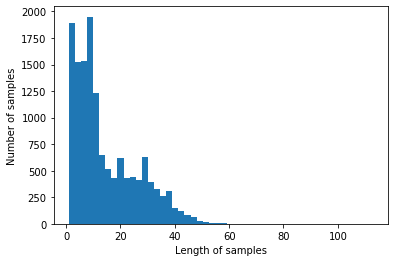

In [35]:
print('MAX length : %d' % max(len(l) for l in sentence_list))
print('AVG length : %f' % (sum(map(len, sentence_list))/len(sentence_list)))
plt.hist([len(s) for s in sentence_list], bins=50)
plt.xlabel('Length of samples')
plt.ylabel('Number of samples')
plt.show()

### 2) Tokenize

In [37]:
max_words = 4000

src_t = Tokenizer(num_words=max_words, oov_token='OOV')
src_t.fit_on_texts(sentence_list)

tar_t = Tokenizer()
tar_t.fit_on_texts(tag_list)

In [39]:
vocab_size = max_words
tag_size = len(tar_t.word_index) + 1
print(vocab_size, tag_size)

4000 10


In [40]:
X_train = src_t.texts_to_sequences(sentence_list)
y_train = tar_t.texts_to_sequences(tag_list)

In [41]:
X_train[0]

[989, 1, 205, 629, 7, 3939, 216, 1, 3]

In [42]:
y_train[0]

[4, 1, 7, 1, 1, 1, 7, 1, 1]

In [43]:
index2word = src_t.index_word
index2ner = tar_t.index_word

In [44]:
index2ner

{1: 'o',
 2: 'b-loc',
 3: 'b-per',
 4: 'b-org',
 5: 'i-per',
 6: 'i-org',
 7: 'b-misc',
 8: 'i-loc',
 9: 'i-misc'}

In [48]:
ex_decoded = []
for index in X_train[0] : 
    ex_decoded.append(index2word[index]) 

빈도 수가 낮은 reject & lamb은 OOV로 대체된 것을 확인할 수 있음!

In [50]:
sentence_list[0]

['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.']

In [49]:
ex_decoded

['eu', 'OOV', 'german', 'call', 'to', 'boycott', 'british', 'OOV', '.']

### 3) Padding

In [51]:
max_len = 70
X_train = pad_sequences(X_train, padding='post', maxlen=max_len)
y_train = pad_sequences(y_train, padding='post', maxlen=max_len)

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=.2, random_state=42)

### 4) One-Hot Encoding

In [56]:
y_train = to_categorical(y_train, num_classes=tag_size)
y_test = to_categorical(y_test, num_classes=tag_size)

In [59]:
print('train 샘플 문장의 크기 : {}'.format(X_train.shape))
print('train 샘플 레이블의 크기 : {}'.format(y_train.shape))
print('test 샘플 문장의 크기 : {}'.format(X_test.shape))
print('test 샘플 레이블의 크기 : {}'.format(y_test.shape))

train 샘플 문장의 크기 : (11232, 70)
train 샘플 레이블의 크기 : (11232, 70, 10)
test 샘플 문장의 크기 : (2809, 70)
test 샘플 레이블의 크기 : (2809, 70, 10)


## 3. Bi-directional LSTM

In [60]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional, TimeDistributed
from tensorflow.keras.optimizers import Adam

### 1) Model Architecture

- embedding vector의 차원 : 128
- LSTM에는 256개의 neuron / return_sequences=True (Many-to-Many 문제이므로)
- TimeDistributed : 10개의 time에 각각 적용!

In [65]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len, mask_zero=True))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(TimeDistributed(Dense(tag_size, activation='softmax')))

In [66]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 70, 128)           512000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 70, 512)           788480    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 70, 10)            5130      
Total params: 1,305,610
Trainable params: 1,305,610
Non-trainable params: 0
_________________________________________________________________


In [67]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

### 2) train

In [68]:
history = model.fit(X_train, y_train, batch_size=128, epochs=4,  validation_data=(X_test, y_test))

Train on 11232 samples, validate on 2809 samples
Epoch 1/4
11232/11232 [==============================] - 185s 16ms/sample - loss: 0.1872 - accuracy: 0.8228 - val_loss: 0.1283 - val_accuracy: 0.8373
Epoch 2/4
11232/11232 [==============================] - 201s 18ms/sample - loss: 0.1010 - accuracy: 0.8516 - val_loss: 0.0806 - val_accuracy: 0.8845
Epoch 3/4
11232/11232 [==============================] - 213s 19ms/sample - loss: 0.0681 - accuracy: 0.9014 - val_loss: 0.0583 - val_accuracy: 0.9184
Epoch 4/4
11232/11232 [==============================] - 222s 20ms/sample - loss: 0.0486 - accuracy: 0.9325 - val_loss: 0.0449 - val_accuracy: 0.9391


### 3) evaluation

In [71]:
model.evaluate(X_test, y_test)[1]

2809/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0.9390847

# 4. Result 

In [72]:
def result_index(i):
    y_pred = model.predict(np.array([X_test[i]]))
    y_pred = np.argmax(y_pred,axis=-1)
    true = np.argmax(y_test[i],-1)
    
    print("{:15}|{:5}|{}".format('word','actual','predicted'))
    print(35*"-")
    
    for w,t,pred in zip(X_test[i], true, y_pred[0]):
        if w!= 0:
            print("{:17}:{:7}{}".format(index2word[w], index2ner[t].upper(),index2ner[pred].upper()))

In [74]:
result_index(13)

word           |actual|predicted
-----------------------------------
amsterdam        :B-LOC  B-LOC
1996-08-28       :O      O


### 정확도는 높게 보임,BUT 대부분의 단어가 개체명이 아니라 'O'이 태깅된 상황! 이를 해결하는 방법 중 하나가 F-1 score를 지표로 사용하는 것!